In [12]:
import requests,zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip
zipref=zipfile.ZipFile('10_food_classes_10_percent.zip','r')
zipref.extractall()
zipref.close()


--2023-08-16 09:32:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   279MB/s    in 0.6s    

2023-08-16 09:32:23 (279 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [13]:
import os

for root,dirs,files in os.walk('.'):
    print("There are ",len(dirs)," directories and ",len(files)," files in ",root)

There are  4  directories and  1  files in  .
There are  2  directories and  7  files in  ./.config
There are  1  directories and  0  files in  ./.config/logs
There are  0  directories and  6  files in  ./.config/logs/2023.08.14
There are  0  directories and  1  files in  ./.config/configurations
There are  1  directories and  1  files in  ./__MACOSX
There are  2  directories and  2  files in  ./__MACOSX/10_food_classes_10_percent
There are  0  directories and  10  files in  ./__MACOSX/10_food_classes_10_percent/train
There are  0  directories and  10  files in  ./__MACOSX/10_food_classes_10_percent/test
There are  2  directories and  0  files in  ./10_food_classes_10_percent
There are  10  directories and  0  files in  ./10_food_classes_10_percent/train
There are  0  directories and  75  files in  ./10_food_classes_10_percent/train/ice_cream
There are  0  directories and  75  files in  ./10_food_classes_10_percent/train/steak
There are  0  directories and  75  files in  ./10_food_clas

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir="./10_food_classes_10_percent/train"
test_dir="./10_food_classes_10_percent/test"

train_dataGen=ImageDataGenerator(rescale=1/255.)
test_dataGen=ImageDataGenerator(rescale=1/255.)

print("Training data:")
train_data=train_dataGen.flow_from_directory(directory=train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode="categorical")
print("Testing data:")
test_data=test_dataGen.flow_from_directory(directory=test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode="categorical")



Training data:
Found 750 images belonging to 10 classes.
Testing data:
Found 2500 images belonging to 10 classes.


In [15]:
import datetime


def tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%M%D-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    return tensorboard_callback


In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [17]:
resnet="https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5"
efficient_net="https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [18]:
def create_model(model_url, num_classes=10):

    # download the pretrained model
    feature_extractor = hub.KerasLayer(
        model_url,
        input_shape=(244, 244, 3),
        trainable=False,
        name="feature_extraction_layers",
    )
    #create our own model
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    return model

In [19]:
train_data.num_classes

10

In [20]:
resnet_model=create_model(resnet)

In [21]:
efficient_net_model=create_model(efficient_net)

In [22]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
History_resnet_model = resnet_model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    callbacks=[tensorboard_callback(dir_name="logs", experiment_name="resnet")],
    steps_per_epoch=len(train_data),
    validation_steps=len(test_data),
)

Epoch 1/5
24/24 [==============================] - 46s 1s/step - loss: 1.9840 - accuracy: 0.3627 - val_loss: 1.1207 - val_accuracy: 0.6476
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 0.8483 - accuracy: 0.7480 - val_loss: 0.8415 - val_accuracy: 0.7328
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.5660 - accuracy: 0.8333 - val_loss: 0.7269 - val_accuracy: 0.7620
Epoch 4/5
24/24 [==============================] - 35s 1s/step - loss: 0.4286 - accuracy: 0.8853 - val_loss: 0.6725 - val_accuracy: 0.7796
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3174 - accuracy: 0.9373 - val_loss: 0.6404 - val_accuracy: 0.7996


In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layers (  (None, 2048)             42605504  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 42,625,994
Trainable params: 20,490
Non-trainable params: 42,605,504
_________________________________________________________________


In [25]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.6404 - accuracy: 0.7996


[0.6404269337654114, 0.7996000051498413]

In [26]:
class_names=train_data.class_indices

print(class_names)

{'chicken_curry': 0, 'chicken_wings': 1, 'fried_rice': 2, 'grilled_salmon': 3, 'hamburger': 4, 'ice_cream': 5, 'pizza': 6, 'ramen': 7, 'steak': 8, 'sushi': 9}


In [27]:
classes=list(class_names.keys())
classes


['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

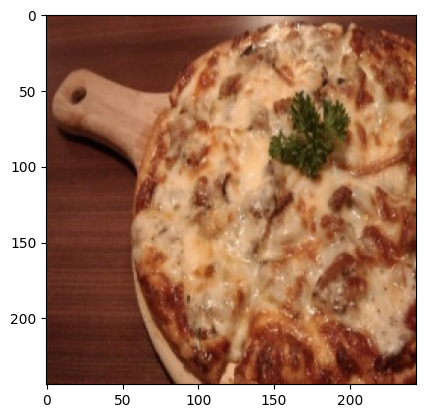

In [28]:
import cv2,matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

test_image=cv2.imread("/content/10_food_classes_10_percent/test/pizza/103708.jpg")

test_image=cv2.resize(test_image,(244,244))
test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
test_image.shape

plt.imshow(test_image)
plt.show()
test_image=np.expand_dims(test_image,axis=0)


In [29]:
#plot a loss curve
def plot_loss_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

#plot a accuracy curve
def plot_accuracy_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

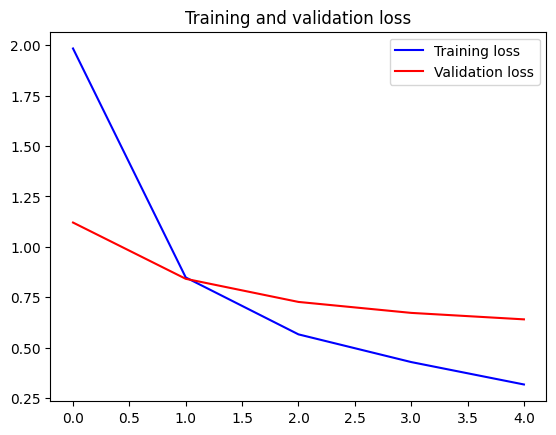

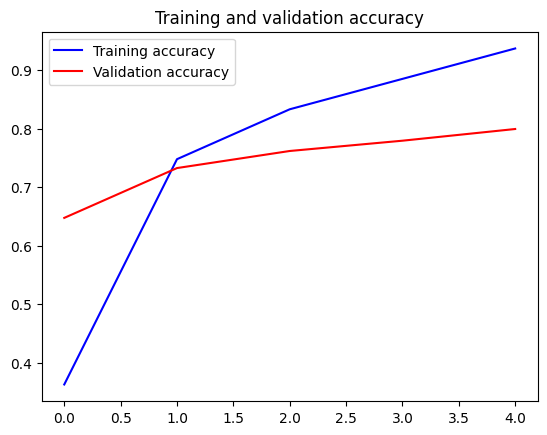

In [30]:
plot_loss_curve(History_resnet_model)
plot_accuracy_curve(History_resnet_model)

In [31]:
efficient_net_model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])

In [32]:
History_EfiicientNet=efficient_net_model.fit(train_data,epochs=5,callbacks=[tensorboard_callback(dir_name="logs", experiment_name="efficientNet")],steps_per_epoch=len(train_data), validation_data=test_data,validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 21s 698ms/step - loss: 1.9367 - accuracy: 0.3893 - val_loss: 1.3796 - val_accuracy: 0.6956
Epoch 2/5
24/24 [==============================] - 12s 511ms/step - loss: 1.1094 - accuracy: 0.7640 - val_loss: 0.9159 - val_accuracy: 0.8052
Epoch 3/5
24/24 [==============================] - 17s 730ms/step - loss: 0.7791 - accuracy: 0.8320 - val_loss: 0.7221 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 16s 705ms/step - loss: 0.6244 - accuracy: 0.8693 - val_loss: 0.6301 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 19s 806ms/step - loss: 0.5245 - accuracy: 0.8973 - val_loss: 0.5699 - val_accuracy: 0.8552


In [33]:
efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layers (  (None, 1280)             4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [34]:
efficient_net_model.evaluate(test_data)

79/79 [==============================] - 9s 108ms/step - loss: 0.5699 - accuracy: 0.8552


[0.5698627233505249, 0.8551999926567078]

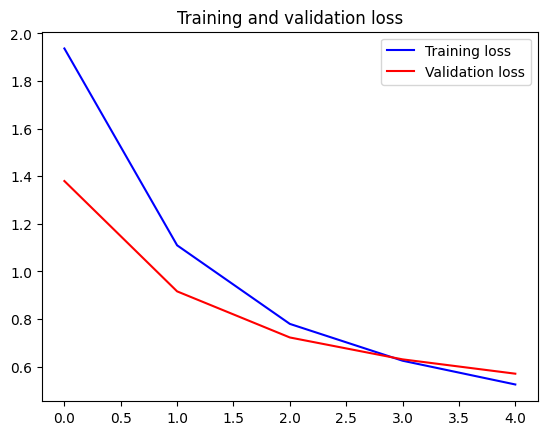

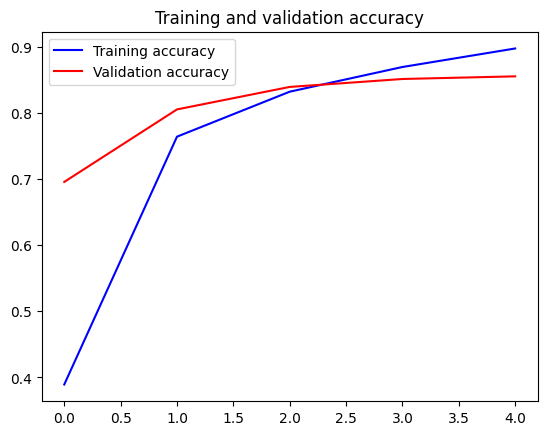

In [35]:
plot_loss_curve(History_EfiicientNet)
plot_accuracy_curve(History_EfiicientNet)

In [36]:
pred=resnet_model.predict(test_image)
classes[np.argmax(pred)]

1/1 [==============================] - 3s 3s/step


'fried_rice'

In [37]:
pred=efficient_net_model.predict(test_image)
index=np.argmax(pred)
classes[index]


1/1 [==============================] - 2s 2s/step


'ice_cream'

In [ ]:
#upload logs to tensorboard dev

!tensorboard dev upload --logdir ./logs/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two tf hub featuring extraction architectures" \
  --one_shot

In [ ]:
# https://tensorboard.dev/experiment/men6s2GgQUGuVhWnaZH5xQ/
